In [210]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import ensemble
%matplotlib inline

### Plot Confusion Matrix

This is a function that will be used later for plotting confusion matrix.

In [211]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load Dataset

In [212]:
# Load dataset
data = pd.read_csv('guns.csv', index_col = 0)
print('The shape of the dataset is (%d, %d)' % (data.shape[0], data.shape[1]))
data.head()

The shape of the dataset is (100798, 10)


,year,month,intent,police,sex,age,race,hispanic,place,education
1,2012,1,Suicide,0,M,34.0,Asian/Pacific Islander,100,Home,4.0
2,2012,1,Suicide,0,F,21.0,White,100,Street,3.0
3,2012,1,Suicide,0,M,60.0,White,100,Other specified,4.0
4,2012,2,Suicide,0,M,64.0,White,100,Home,4.0
5,2012,2,Suicide,0,M,31.0,White,100,Other specified,2.0


### Missing data

In [213]:
# Determine the number of missing values in each feature
missing_feature = data.isnull().sum()

# Determine the total number of missing values
missing = data.isnull().sum().sum()

print('The number of missing values in each feature:')
print(missing_feature)
print('\n')
print('The total number of data points with missing values: %d' % missing)

The number of missing values in each feature:
year            0
month           0
intent          1
police          0
sex             0
age            18
race            0
hispanic        0
place        1384
education      53
dtype: int64


The total number of data points with missing values: 1456


### Fixing Missing Data

In [214]:
# Manually fill in the missing data values
#data["place"] = data.groupby("race").transform(lambda x: x.fillna( x.value_counts().idxmax() ))["place"]
data["education"] = data.groupby("race").transform(lambda x: x.fillna( x.value_counts().idxmax() ))["education"]
#data["age"] = data.groupby("race").transform(lambda x: x.fillna( x.value_counts().idxmax() ))["age"]

# Try to see if the missing data values are filled
#data.isnull().sum()

### Drop missing values

In [191]:
# Create another dataset without the missing values
data_nm = data.dropna(axis=0, how='any').reset_index(drop=True)
print('The shape of the dataset is (%d, %d)' % (data_nm.shape[0], data_nm.shape[1]))

The shape of the dataset is (99396, 10)


### Min-Max Scale

In [192]:
# Min-max scale
min_max_scaler = preprocessing.StandardScaler()
data_age_minmax = min_max_scaler.fit_transform(np.float32(data_nm['age'].values.reshape(-1,1)))
data_nm['age'] = data_age_minmax

data_education_minmax = min_max_scaler.fit_transform(np.float32(data_nm['education'].values.reshape(-1,1)))
data_nm['education'] = data_education_minmax

data_hispanic_minmax = min_max_scaler.fit_transform(np.float32(data_nm['hispanic'].values.reshape(-1,1)))
data_nm['hispanic'] = data_hispanic_minmax

In [193]:
data_nm.head()

,year,month,intent,police,sex,age,race,hispanic,place,education
0,2012,1,Suicide,0,M,-0.509799,Asian/Pacific Islander,-0.228613,Home,1.717763
1,2012,1,Suicide,0,F,-1.174775,White,-0.228613,Street,0.707922
2,2012,1,Suicide,0,M,0.820153,White,-0.228613,Other specified,1.717763
3,2012,2,Suicide,0,M,1.024761,White,-0.228613,Home,1.717763
4,2012,2,Suicide,0,M,-0.663255,White,-0.228613,Other specified,-0.301918


### Remove features & create dummy variables


In [194]:
# Remove irrelevant features "year" and "month"
data_nm = data_nm.drop(['year', 'month'], axis=1)

# One-hot-encode the data
X = pd.get_dummies(data_nm.drop('race', axis=1))
y = data_nm['race']

In [195]:
# See the distribution of each value in our target variable
distribution = y.value_counts() / y.count()
print(distribution)

White                             0.659262
Black                             0.230794
Hispanic                          0.087941
Asian/Pacific Islander            0.013039
Native American/Native Alaskan    0.008964
Name: race, dtype: float64


### Train/Test Split

In [196]:
# Split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify = y)


print('The size of X_train is: (%d, %d)' % (X_train.shape[0], X_train.shape[1]))
print('The size of y_train is: (%d)' % (y_train.shape[0]))
print('The size of X_test is: (%d, %d)' % (X_test.shape[0], X_test.shape[1]))
print('The size of y_test is: (%d)' % (y_test.shape[0]))

The size of X_train is: (79516, 20)
The size of y_train is: (79516)
The size of X_test is: (19880, 20)
The size of y_test is: (19880)


### Logistic Regression

In [197]:
# Fit a logistic regression model using X_train and y_train with default parameters
log_reg = LogisticRegression(max_iter = 150)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 score for X_train is: 0.853464
The f1 score for X_test is: 0.855660
Confusion matrix, without normalization
[[    0   318     0   717     0]
 [    0 14381     0  3916     0]
 [    0     0     0     0     0]
 [    0  4471     0 47780     0]
 [    0   209     0   501     0]]


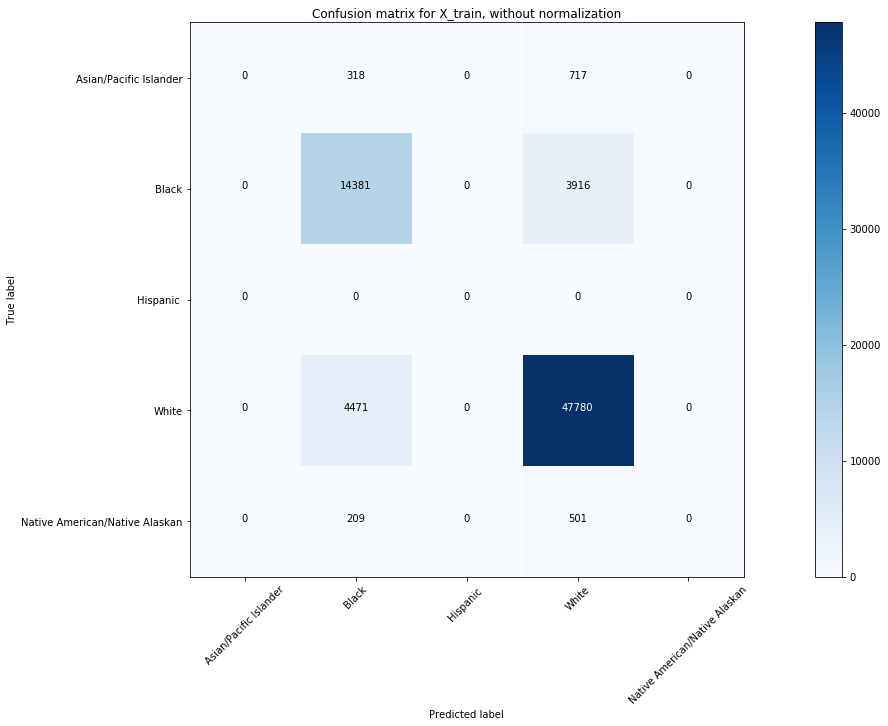

In [198]:
# Target names
target_names = ['Asian/Pacific Islander', 'Black', 'Hispanic ', 'White', 'Native American/Native Alaskan']

# F1 score on X_train
X_train_predict = log_reg.predict(X_train)
f1_xtrain = metrics.f1_score(y_train, X_train_predict, average = 'weighted')
print("The f1 score for X_train is: %f" % f1_xtrain)

# F1 score on X_test
X_test_predict = log_reg.predict(X_test)
f1_xtest = metrics.f1_score(y_test, X_test_predict, average = 'weighted')
print("The f1 score for X_test is: %f" % f1_xtest)

# Confusion Matrix on X_train
X_train_confusion = metrics.confusion_matrix(y_train, X_train_predict, labels = target_names)
plt.figure(figsize=(20,10))
plot_confusion_matrix(X_train_confusion, classes=target_names,
                      title='Confusion matrix for X_train')

### Create Polynomial Features

In [199]:
# Create polynomial features
poly = preprocessing.PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
print(X_train_poly.shape)
print(X_test_poly.shape)

(79516, 231)
(19880, 231)


In [200]:
# Instantiate another logistic regression model on polynomial features
log_reg_2 = LogisticRegression(max_iter = 300)
log_reg_2.fit(X_train_poly, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [201]:
final_train_prediction_poly = log_reg_2.predict(X_train_poly)
f1_train_poly = metrics.f1_score(y_train, final_train_prediction_poly, average = 'weighted')

final_test_prediction_poly = log_reg_2.predict(X_test_poly)
f1_test_poly = metrics.f1_score(y_test, final_test_prediction_poly, average = 'weighted')

final_classification_poly = metrics.classification_report(y_test, final_test_prediction_poly , target_names = target_names)

print("The f1 score for X_train_poly is: %f" % f1_train_poly)
print("The f1 score for X_test_poly is: %f" % f1_test_poly)
print(final_classification_poly)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.866434802056
0.86288656175
                                precision    recall  f1-score   support

        Asian/Pacific Islander       0.00      0.00      0.00       259
                         Black       0.76      0.77      0.77      4588
                     Hispanic        1.00      1.00      1.00      1749
                         White       0.00      0.00      0.00       178
Native American/Native Alaskan       0.90      0.92      0.91     13106

                   avg / total       0.86      0.88      0.87     19880



C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Cross-Validation to search for regularization lambda

In [112]:
# Instantiate another logistic regression model
log_reg_2 = LogisticRegression(max_iter = 150)

# F1 Scorer
f1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# C list
C_list = range(0, 1000) # 3, 1000, 1200, 1400, 1600

# Param grid
param_grid = dict(C = C_list)

In [113]:
grid = RandomizedSearchCV(log_reg_2 , param_grid, cv = 3, n_iter = 9, scoring = f1_scorer, random_state = 24)
grid.fit(X_train_poly, y_train)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classi

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=9, n_jobs=1,
          param_distributions={'C': range(0, 1000)},
          pre_dispatch='2*n_jobs', random_state=24, refit=True,
          return_train_score=True,
          scoring=make_scorer(f1_score, average=weighted), verbose=0)

In [114]:
# See grid scores
print(grid.grid_scores_)

# Use the best logistic regression
final_log_reg = grid.best_estimator_

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.86233, std: 0.00205, params: {'C': 418},
 mean: 0.86233, std: 0.00205, params: {'C': 899},
 mean: 0.86231, std: 0.00204, params: {'C': 192},
 mean: 0.86232, std: 0.00202, params: {'C': 343},
 mean: 0.86233, std: 0.00205, params: {'C': 401},
 mean: 0.86232, std: 0.00204, params: {'C': 145},
 mean: 0.86235, std: 0.00206, params: {'C': 129},
 mean: 0.86233, std: 0.00205, params: {'C': 356},
 mean: 0.86233, std: 0.00205, params: {'C': 123}]

In [115]:
# Predict on X_test
final_test_prediction_poly = final_log_reg.predict(X_test_poly)
f1_final_poly = metrics.f1_score(y_test, final_test_prediction_poly, average = 'weighted')

print(f1_final_poly)

LogisticRegression(C=129, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)